In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Inspect the database for the column names and data types in each table
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Using the inspector to print the column names within the `measurement` table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Using the inspector to print the column names within the `station` table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Find the most recent date in the data set
session.query(measurement.date).order_by(measurement.date.desc()).first() # This piece of info will be used for the Climate App.

('2017-08-23')

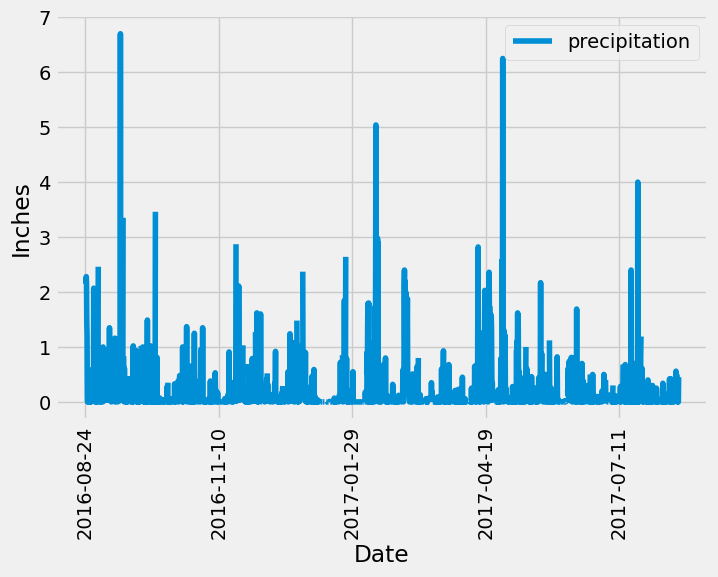

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Starting from the most recent data point in the database
end_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

# Calculate the date one year from the last date in data set
start_date = dt.datetime.strptime(end_date[0], '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date>=start_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results).set_index('date')

# Sort the dataframe by date
df.sort_index(inplace=True)

# Set global figure size and dpi
plt.rcParams["figure.figsize"] = (7.5, 5)
plt.rcParams["figure.dpi"] = 100

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(['precipitation'], loc='upper right');

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(station).group_by(station.name).count()

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order
results = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
most_active_id = results[0][0]
print(f'The station id that sees the greatest number of observations is {most_active_id}.')

The station id that sees the greatest number of observations is USC00519281.


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
(min, max, avg) = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station==most_active_id).first()
print(f'The min, max, and average temperatures for {most_active_id} are {min:.1f}, {max:.1f}, and {avg:.1f}.')

The min, max, and average temperatures for USC00519281 are 54.0, 85.0, and 71.7.


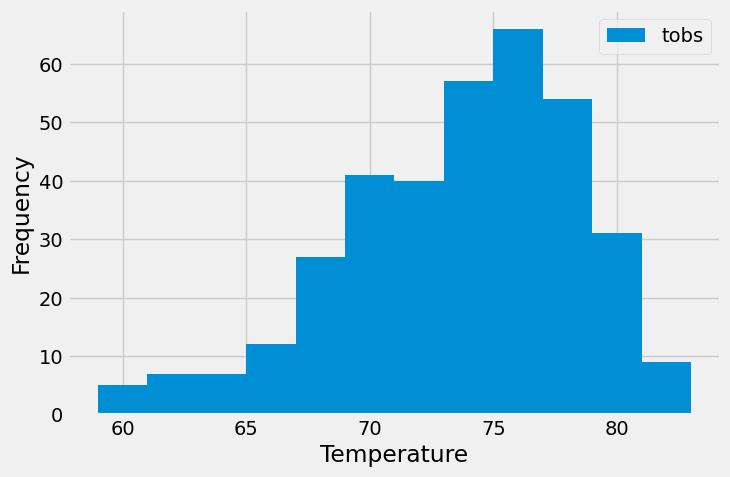

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Find the most recent data point in the database for the most active station
end_date = session.query(measurement.date).\
    order_by(measurement.date.desc()).filter(measurement.station==most_active_id).first()

# Calculate the date one year from the last date in data set
start_date = dt.datetime.strptime(end_date[0], '%Y-%m-%d') - dt.timedelta(days=365)

# Query the previous 12 months of TOBS data
results = session.query(measurement.tobs).\
    filter(measurement.date>=start_date).filter(measurement.station==most_active_id).all()

# Save the query results as a series
temperature = [record[0] for record in results]

# Plot the results as a histogram with 12 bins
plt.hist(temperature, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs']);

# Close session

In [19]:
# Close Session
session.close()